In [1]:
from pathlib import Path
import pandas as pd

from expense_models import load_expenses, expenses_to_dataframe

In [2]:
expenses_path = Path("2025-11-07.json")
expenses = load_expenses(expenses_path)

len(expenses)

df = expenses_to_dataframe(expenses)
df


,name,category,account_id,yearly_value_eur,monthly_value_eur,yearly_value,monthly_value,currency,value,repeat_every,repeat_every_unit,description
0,Rent,Housing,activo_bank,8460.00,705.00,8460.00,705.00,EUR,705.00,1,months,None
1,Revolution food,Food,activo_bank,2139.28,178.27,2139.28,178.27,EUR,41.00,1,weeks,None
2,Cleaning,Housing,activo_bank,1087.03,90.59,1087.03,90.59,EUR,62.50,3,weeks,None
3,Contabilizei,Business,nubank_cnpj,717.78,59.82,4428.00,369.00,BRL,369.00,1,months,None
4,Energy,Housing,activo_bank,426.84,35.57,426.84,35.57,EUR,35.57,1,months,None
5,Metilfolato,Health,activo_bank,370.60,30.88,370.60,30.88,EUR,30.44,30,days,1000mcg x 90comp
6,T3,Health,activo_bank,351.20,29.27,351.20,29.27,EUR,86.54,90,days,None
7,Vodafone,Utilities,activo_bank,342.00,28.50,342.00,28.50,EUR,28.50,1,months,None
8,Internet,Housing,activo_bank,309.00,25.75,309.00,25.75,EUR,25.75,1,months,None
9,Heroku - Teya,Business,nubank_cnpj,288.00,24.00,288.00,24.00,EUR,24.00,1,months,None


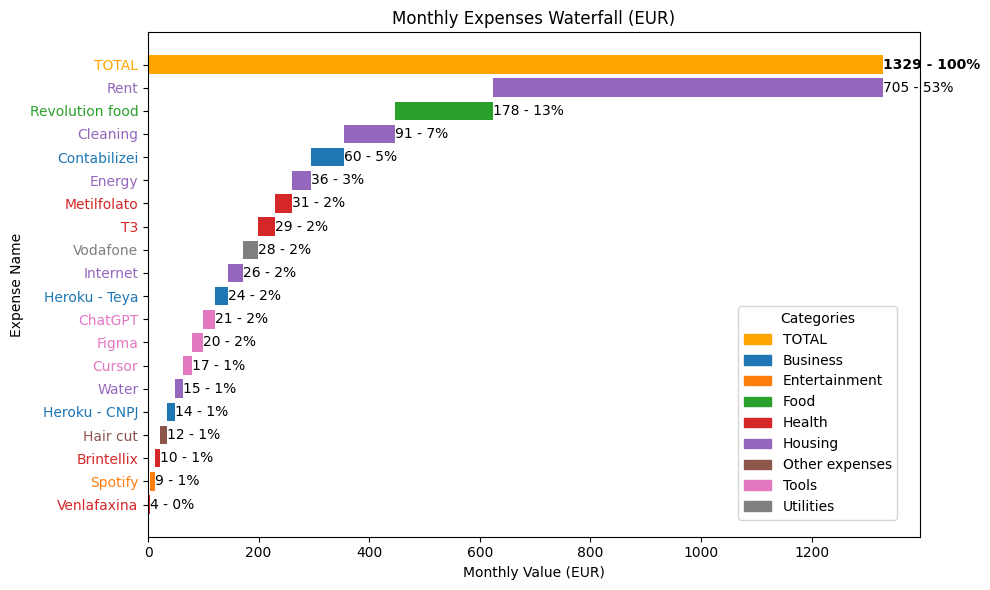

In [3]:
from expense_charts import plot_expenses_waterfall

plot_expenses_waterfall(df)

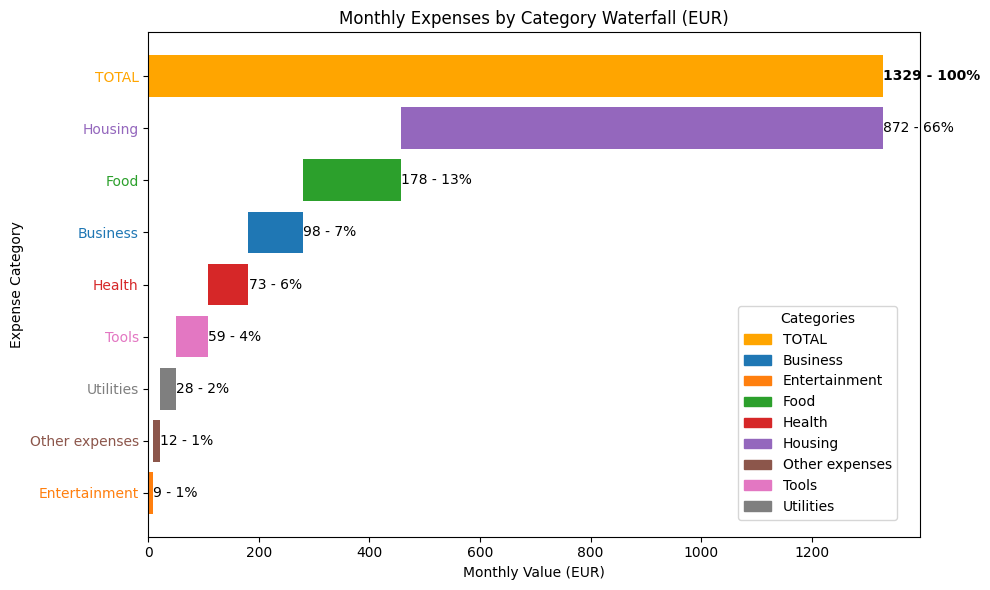

In [4]:
from expense_charts import plot_category_waterfall

plot_category_waterfall(df)
